# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [25]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [27]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

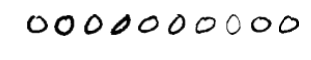

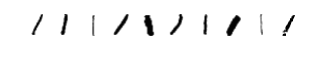

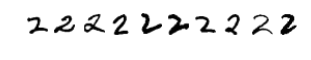

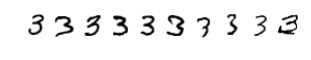

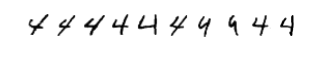

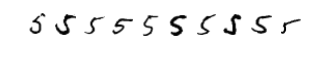

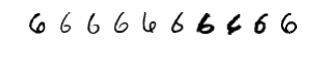

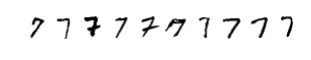

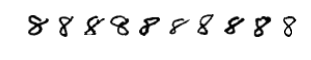

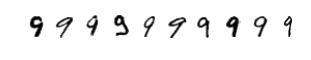

In [3]:
### P1 STUDENT START ###

def create_tenlist(num_examples, labelset):
    # This function creates ten lists of length num_examples.
    # Each list contains row-indexes of examples of those digits in the dataset, indicated by labelset. 
    count = 0
    tenlist = [[] for i in range(num_examples)]
    undone = True
    while undone: 
        # the value of the label becomes the index of the list in tenlist
        a = int(labelset[count])
        if len(tenlist[a]) < num_examples:
            tenlist[a].append(count)
        count += 1
        test = sum([len(tenlist[j]) for j in range(10)])
        if test == num_examples**2:
            undone = False
    return tenlist

def P1(num_examples, labels, data):
    plt.close('all')
    tenlist = create_tenlist(num_examples, labels)    
    for k in range(len(tenlist)):
        v = tenlist[k]
        plt.figure(figsize=(5,5))
        plt.subplots_adjust(hspace=0.0, wspace=0.0)
        plt.set_cmap('Greys')       
        for digit in range(num_examples):
            plt.subplot(k+1,num_examples,digit+1)
            plt.axis('off')
            c= data[v[digit]]
            c2 = np.reshape(c, (28,28))
            plt.imshow(c2)
        
### STUDENT END ###

P1(10, mini_train_labels, mini_train_data)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [4]:
### P2 STUDENT START ###

def knn_modelfit(k):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(mini_train_data, mini_train_labels) 
    return knn_model.score(dev_data, dev_labels), knn_model.predict(dev_data)

def P2(k_values):
    print "Accuracy of k_values on dev set:"
    print "k\tScore"
    for val in k_values:
        print val, "\t", knn_modelfit(val)[0]  
    
    label_values = [0., 1., 2., 3., 4.,5.,6.,7.,8.,9.]
    y_pred = knn_modelfit(1)[1]
    Z = classification_report(dev_labels, y_pred)
    print "\nClassification Report"
    print Z
    
k_values = [1, 3, 5, 7, 9]
P2(k_values)    

Accuracy of k_values on dev set:
k	Score
1 	0.888
3 	0.878
5 	0.869
7 	0.865
9 	0.863

Confusion Matrix
             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000



ANSWER: Please see output of above code block for accuracy of k_values on the dev set, and a printout of the resulting confusion matrix. The highest accuracy is achieved with k=1, although the spread of accuracies (scores) for the different k-values is only 0.025. According to the Confusion Matrix, the digit with the lowest F1 score is 9, with an F1 of 0.80, therefore I conclude that 9 is the most difficult digit to predict.  

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [34]:
### P3 STUDENT START ###

def P3(train_sizes, accuracies):
    
    knn_model = KNeighborsClassifier(n_neighbors=1) 
    print "Size\tAccuracy\tProcessing Time"
    for i in train_sizes:
        begin = time.time()
        train_data, train_labels = X[:i], Y[:i]
        knn_model.fit(train_data, train_labels)
        preds = knn_model.predict(dev_data)
        correct = 0
        total = 0
        for pred, label in zip(preds, dev_labels):
            if pred == label: 
                correct += 1
            total += 1
        acc = 1.0*correct/total
        end = time.time()
        accuracies.append(acc)
        print "%i\t%.3f\t\t%.5f  seconds" %(i,acc,end-begin)

### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

Size	Accuracy	Processing Time
100	0.704		0.12102  seconds
200	0.791		0.23284  seconds
400	0.849		0.44246  seconds
800	0.870		0.92137  seconds
1600	0.902		1.86160  seconds
3200	0.931		3.71586  seconds
6400	0.941		7.53942  seconds
12800	0.954		15.89184  seconds
25000	0.964		33.89849  seconds


(3) ANSWER: Please see above displayed results showing training set size, accuracy, and processing time. The processing time is a roughly exponential growth following the roughly exponential growth of the training set size. 

(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [46]:
### P4 STUDENT START ###
def data_prep(accuracies, train_sizes):
    # turn the data into np input matrix and output vector.
    in_X = [[i] for i in train_sizes]
    in_X = np.asarray(in_X)
    target_Y = [[i] for i in accuracies]
    target_Y = np.asarray(target_Y)
    return in_X, target_Y

def P4():
    # First fit linear model:
    print "Accuracy (R^2)\tPrediction(60000)\tModel"
    in_X, target_Y = data_prep(accuracies, train_sizes)
    lin_model = LinearRegression(fit_intercept=True)
    lin_model.fit(in_X, target_Y)
    print "%.3f\t\t%.3f\t\t\tUntransformed data linear regression model" %(lin_model.score(in_X, target_Y), 
                                                                          lin_model.predict([60000]))
    # Transform x-axis data using logarithm:
    log_in_X = np.log(in_X)
    lin_model.fit(log_in_X, target_Y)
    testvalue = np.log(60000)
    print "%.3f\t\t%.3f\t\t\tLogarithm of Input Values" %(lin_model.score(log_in_X, target_Y), 
                                                                     lin_model.predict([testvalue])) 
    # Transform both x-axis and y-axis data: 
    log_target_Y = np.log(target_Y)
    lin_model.fit(log_in_X, log_target_Y)
    print "%.3f\t\t%.3f\t\t\tLogarithm of Input and Output" %(lin_model.score(log_in_X, log_target_Y), 
                                                                     np.exp(lin_model.predict([testvalue])))
    
    lin_model.fit(in_X, log_target_Y)
    print "%.3f\t\t%.3f\t\t\tLogarithm of Output" %(lin_model.score(in_X, log_target_Y), 
                                                                     np.exp(lin_model.predict([testvalue])))
    

### STUDENT END ###

P4()

Accuracy (R^2)	Prediction(60000)	Model
0.403		1.234			Untransformed data linear regression model
0.886		1.034			Logarithm of Input Values
0.857		1.050			Logarithm of Input and Output
0.372		0.838			Logarithm of Output


ANSWER: Taking the log of the input variable improves the R^2 value from 40% to 89%. Taking logs of both input and output results in R^2 of 86%, not quite as good. The input training size values show a strong exponential relationship, with clustering near zero, so it makes sense to use the log transform on the training sizes. Taking the log transform of both input and output data did not improve the R^2 value, and transforming only the output values made the R^2 value much worse. The predicted accuracy for 60000 in the output-transform-only case is less than the accuracy for 25000, which does not follow the increasing trend of accuracy with training set size. I conclude the log of the x-values is the most sensible transform. 

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

index [4, 9]
predicted [ 9.  9.  9.  9.  9.  9.  9.  9.  9.  9.]


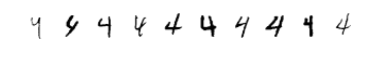

In [47]:
### P5 Student Start ###

def off_diagonal_max(matrix):
    max_value = matrix[0][1]
    index = [0, 1]
    for i in range(len(matrix)):
        for j in range(i+1, len(matrix[0])):
            if matrix[i][j] > max_value:
                max_value = matrix[i][j]
                index = [i, j]
        for k in range(0,i):
            if matrix[i][k] > max_value:
                max_value = matrix[i][k]
                index = [i, k]
    return max_value, index

def print_3confused(index, prediction):
    # This function prints 10 examples of numbers that were predicted incorrectly. 
    # The list "index" contains these two mixed up numbers.
    real_num = float(index[0])
    pred_num = float(index[1])
    mask_real = (dev_labels == real_num)
    mask_pred = (prediction == pred_num)
    mask = (mask_real & mask_pred)
    # capture examples of confused numbers. 
    indexlist = []
    count = 0
    lenlist = 10
    while len(indexlist) < lenlist: 
        if mask[count]:
            indexlist.append(count)
        count +=1
    #print "indexlist", indexlist
    for i in range(lenlist):
        plt.subplot(1,lenlist,i+1)
        plt.axis('off')
        row4 =  dev_data[indexlist[i]]
        row4reshape = np.reshape(row4, (28,28))
        plt.imshow(row4reshape)
    print "predicted", prediction[indexlist]
               
def P5():

### STUDENT START ###
    knn_model = KNeighborsClassifier(n_neighbors=1)
    knn_model.fit(mini_train_data, mini_train_labels)
    cmatrix = confusion_matrix(dev_labels, knn_model.predict(dev_data))
    max, index = off_diagonal_max(cmatrix)
    print "index", index
    prediction = knn_model.predict(dev_data)
    print_3confused(index, prediction)
    
### STUDENT END ###
P5()


(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

1-NN Control:		0.876
1-NN Blur Train:	0.91
1-NN Blur Dev:		0.858
1-NN Blur Both:		0.904


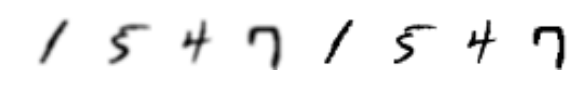

In [50]:
### P6 Student Start ###

def pixel_average(dataset):
    # create list of indices of inner pixels - will not transform pixels on edge of 28x28 array
    #row_init = [0.0 for i in dataset[0]]
    #newdata = [row_init for row in dataset]
    newdata = np.copy(dataset)
    special_indexes = [i for i in range(29,756) if (np.mod(i,28) != 0) if np.mod(i,28) != 27]
    for j in range(len(newdata)):
        new = newdata[j]
        old = dataset[j]
        for idx in special_indexes:
            new[idx] = 0.2*old[idx] + 0.1*(old[idx-29] + old[idx-28] + old[idx-27] + old[idx-1] + old[idx+1]
                                           + old[idx+27] + old[idx+28] + old[idx+29])
    return newdata

def print_test(blur, dataset):
    plt.close('all')
    plt.figure(figsize = (10.0, 10.0))
    for i in range(4):
        plt.subplot(1,8,i+1)
        plt.axis('off')
        row =  blur[4+i]
        rowreshape = np.reshape(row, (28,28))
        plt.imshow(rowreshape)
    for j in range(4,8):
        plt.subplot(1,8,j+1)
        plt.axis('off')
        rowdata =  dataset[j]
        rowreshape = np.reshape(rowdata, (28,28))
        plt.imshow(rowreshape)

def knn_blur_test(k, traindata, trainlabels, testdata, testlabels):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(traindata, trainlabels) 
    return knn_model.score(testdata, testlabels), knn_model.predict(testdata)

def gaussian_blur(traindata, trainlabels, testdata, testlabels):
    clf = GaussianNB()
    clf.fit(traindata, trainlabels)
    return clf.score(testdata, testlabels), clf.predict(testdata)
    
def P6():    
    # Take pixel averages of datasets:
    blur_mini_train = pixel_average(mini_train_data)
    blur_dev = pixel_average(dev_data)
    # print four examples of blurred digits and corresponding un-blurred digits
    print_test(blur_mini_train, mini_train_data)
    # print test scores using 1-NN model:
    print "1-NN Control:\t\t", knn_blur_test(3, mini_train_data, mini_train_labels, dev_data, dev_labels)[0]
    print "1-NN Blur Train:\t", knn_blur_test(3, blur_mini_train, mini_train_labels, dev_data, dev_labels)[0]
    print "1-NN Blur Dev:\t\t", knn_blur_test(3, mini_train_data, mini_train_labels, blur_dev, dev_labels)[0]
    print "1-NN Blur Both:\t\t", knn_blur_test(3, blur_mini_train, mini_train_labels, blur_dev, dev_labels)[0]
    #print "GaussianNB Control:\t", gaussian_blur(mini_train_data, mini_train_labels, dev_data, dev_labels)[0]
    #print gaussian_blur(blur_mini_train, mini_train_labels, dev_data, dev_labels)[0]
    #print gaussian_blur(mini_train_data, mini_train_labels, blur_dev, dev_labels)[0]
    #print gaussian_blur(blur_mini_train, mini_train_labels, blur_dev, dev_labels)[0]

### STUDENT END ###

P6()

ANSWER: Please see the above output. I blurred the data by taking a weighted average of pixels, with the central pixel weighted twice as much as the edge pixels. Four blurred digits and corresponding unblurred digits are displayed. With no blurring, the 1-NN model score was about 88%; with blurring of the training data, there is an improvement to 91%. With blurring of only the dev data, the results are worsened, to 86%, and blurring both was a little worse than blurring the training data only, 90%. 

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

BernoulliNB score:	0.826
MultinomialNB score:	0.795


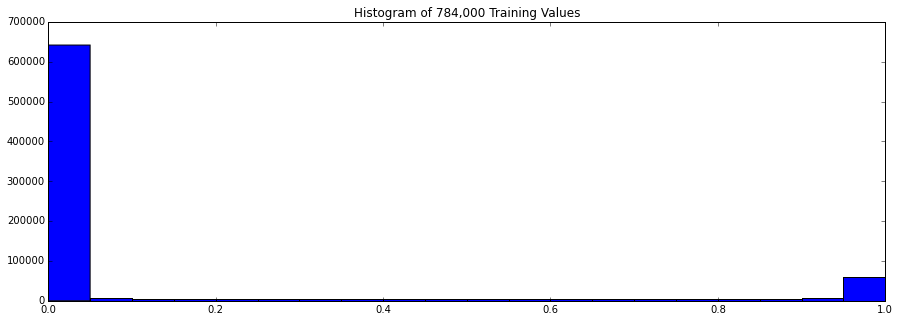

In [54]:
### P7 STUDENT START ###
def three_shades(x):
    y = 0
    if x > 0.0075:
        y = 1
    elif x > 0.97:
        y = 2
    return y
        
def process_three(dataset):
    # This function turns a single valued function into a vector->vector function. 
    # In particular, this maps the dataset from continuous to three-valued data. 
    functionForMapping  = np.vectorize(three_shades)  
    three_valued = functionForMapping(dataset)
    return three_valued

def P7():

    clf = BernoulliNB(alpha=0.01, binarize=0.5)
    clf.fit(mini_train_data, mini_train_labels)
    print "BernoulliNB score:\t", clf.score(dev_data, dev_labels)
    
    # multinomial fit
    mlf = MultinomialNB()
    train_three = process_three(mini_train_data)
    dev_three = process_three(dev_data)
    mlf.fit(train_three, mini_train_labels)
    print "MultinomialNB score:\t", mlf.score(dev_three, dev_labels)
    
    # print a historgram of the 1000x784 mini_train_data dataset:
    plt.close('all')
    big_vector = np.reshape(mini_train_data, (784000,1))
    plt.figure(figsize = (15.0, 5.0))
    plt.hist(big_vector, 20)
    plt.title('Histogram of 784,000 Training Values')
    plt.show
        
### STUDENT END ###

P7()

ANSWER: The BernoulliNB model tends to outperform the MultinomialNB model by 2 or more percent, depending on the value of alpha and threshold for binarizing the data. The MulinomialNB model scores vary a little according to the thresholds for assigning pixel values to 0, 1, or 2, but remain worse than the BernoulliNB model. A histogram of the raw pixel data does show two clusters near 0 and 1, and qualitatively speaking it appears that a binary breakdown of the data is "better" - closer to reality. Very few pixels fall into the "gray" range. 

Furthermore, since a guiding assumption of naive Bayes models is conditional independence of the features, I hypothesize that more independence errors would propagate with a three-level model than a two-level model; the pixel colors on the digit-borders are not likely to be independent. I think there is some support for this hypothesis in the fact that if I tweak the white/grey/black thresholds to match the above histogram, I do not get better MultinomialNB scores. 

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [58]:
def P8(alphas):

### STUDENT START ###
    clf = GridSearchCV(BernoulliNB(), alphas, cv=10, scoring='f1')
    clf.fit(mini_train_data, mini_train_labels) # running the grid search 
    return clf

### STUDENT END ###

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)
print "Grid Scores", nb.grid_scores_
print "Best Alpha:", nb.best_params_

Grid Scores [mean: 0.02107, std: 0.00109, params: {'alpha': 0.0}, mean: 0.83660, std: 0.05030, params: {'alpha': 0.0001}, mean: 0.84028, std: 0.04899, params: {'alpha': 0.001}, mean: 0.84256, std: 0.04900, params: {'alpha': 0.01}, mean: 0.83773, std: 0.05208, params: {'alpha': 0.1}, mean: 0.83326, std: 0.05258, params: {'alpha': 0.5}, mean: 0.82560, std: 0.06048, params: {'alpha': 1.0}, mean: 0.81374, std: 0.06142, params: {'alpha': 2.0}, mean: 0.72502, std: 0.04694, params: {'alpha': 10.0}]
Best Alpha: {'alpha': 0.01}


ANSWER: The best value for alpha turned out to be 0.01 in this run. In other runs, the best alpha was 0.001. The accuracy when alpha is zero is low, a mean of 0.02 in this run. I also ran the larger train_data and train_labels, with similar results for scores and best alpha values. I did not expect alpha=0 to have such a low value. I'm also surprised that only a small positive value of alpha makes a large impact on accuracy. I'm not surprised that there is the alpha curve follows diminishing returns as alpha is increased. The fact that alpha has an effect does seem to correspond to the fact that blurring improved the 1-NN results. 

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

No tweaking:	0.666
Result with noise:	0.813


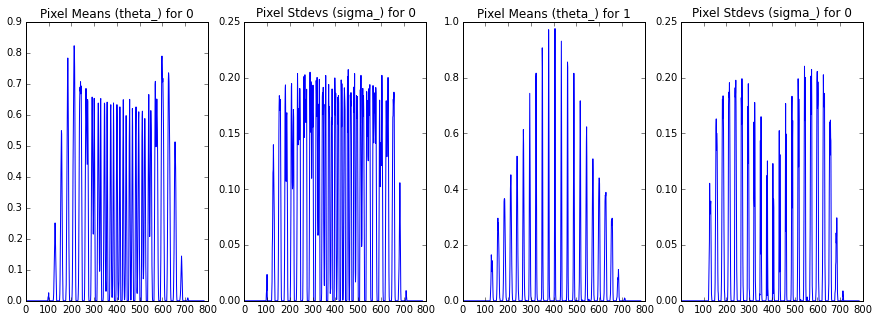

In [67]:
### P9 STUDENT START ###
def add_noise(dataset):
    # This is an attempt to fix the problem of heavily-zero theta_ and sigma_
    # Introduce some random noise into the data
    newdata = np.copy(dataset)
    rows = len(newdata)
    cols = len(newdata[0])
    noise_sample = np.random.random_sample((rows, cols))
    newdata = newdata + noise_sample
    return newdata
    
def P9():

    gnb = GaussianNB()
    
    gnb.fit(mini_train_data, mini_train_labels)
    print "No tweaking:\t", gnb.score(dev_data, dev_labels)
    
    # Printing four examples blurred/not blurred:
    plt.close('all')
    plt.figure(1, figsize = (15.0,5.0))
    plt.subplot(1,4,1)
    plt.plot(gnb.theta_[0])
    plt.title('Pixel Means (theta_) for 0')
    plt.subplot(1,4,2)
    plt.plot(gnb.sigma_[0])
    plt.title('Pixel Stdevs (sigma_) for 0')
    plt.subplot(1,4,3)
    plt.plot(gnb.theta_[1])
    plt.title('Pixel Means (theta_) for 1')
    plt.subplot(1,4,4)
    plt.plot(gnb.sigma_[1])
    plt.title('Pixel Stdevs (sigma_) for 0')
    plt.show
    
    # Try adding noise to make theta_ and sigma_ distributions
    # less spikey
    noisy_data = add_noise(mini_train_data)
    noisy_dev = add_noise(dev_data)
    gnb.fit(noisy_data, mini_train_labels)
    print "Result with noise:\t", gnb.score(noisy_dev, dev_labels)
    # Try setting theta_ and sigma_ to constant values of 0.45 and 0.08
    # and see what results are like, without added noise
    theta_matrix = np.ones([10, len(mini_train_data[0])])*0.45
    sigma_matrix = np.ones([10, len(mini_train_data[0])])*0.08
    
    # Was not able to set_params on my version of python
    # error message in base.py showed that there are no "valid" params in GaussianNB
    # clf = GaussianNB()
    #clf.theta_ = theta_matrix
    #clf.sigma_ = sigma_matrix
    # clf.set_params(theta_=theta_matrix, sigma_=sigma_matrix)
    # clf.fit(mini_train_data, mini_train_labels)
                            
    
### STUDENT END ###

P9()


ANSWER: Please refer to the results in the above code block. Without any data transform, the score for my Gaussian NB model was about 63%. The theta\_ and sigma\_ values (mean and standard deviation for pixel distributions) had many zeros. Furthermore, as the graphs show above for the digits 0 and 1, the means and standard deviations have very spikey profiles (like delta functions). Because the Gaussian distribution function has a sigma in the denominator and exp(-1/sigma), if sigma is close to zero it is like infinity\*zero which is unstable. Since the distributions are spikey, there is further instability in the distribtion functions and corresponding prior probability estimates. 

If random noise is added to the data, the score is about 81%, an improvement to the level of the BernoulliNB classifier. Examination of the theta\_ and sigma\_ values in this case showed theta values of about 0.45, and sigma values of about 0.08, throughout. 

I tried to set theta\_ and sigma\_ to more reasonable values using gnb.set_params according to the scikit documentation, but it did not seem to work. Adding noise is a pretty easy fix. 

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

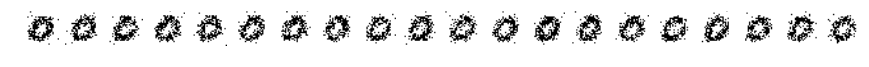

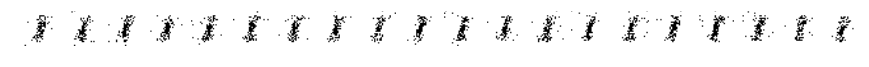

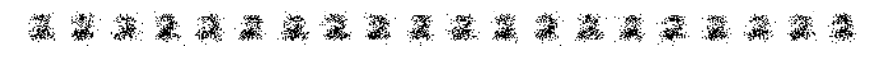

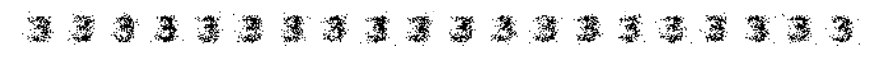

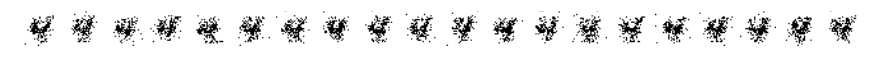

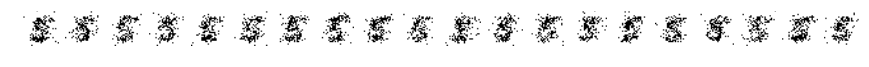

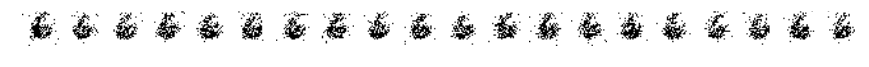

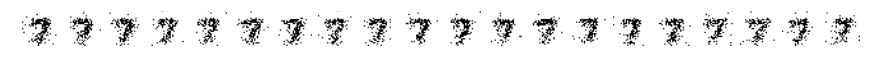

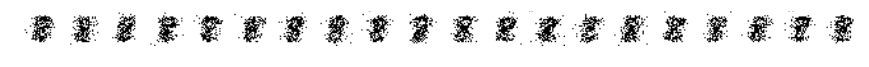

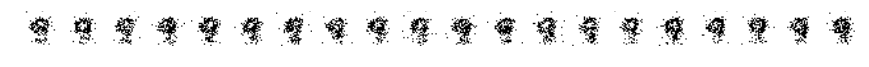

In [68]:
### P10 STUDENT START ###

# My idea is to fit a BernoulliNB model, and obtain the feature probabilities for each pixel. 
# To generate a number, I compare each pixel probability to a random number to determine whether
# the pixel is on or off. Then print. 
def random_vector(rows, cols):
    # Generate random numbers for each pixel. 
    noise_sample = np.random.random_sample((rows, cols))
    return noise_sample

def P10(num_examples):
    # First fit the BernoulliNB model: 
    clf = BernoulliNB()
    clf.fit(mini_train_data, mini_train_labels)
    # Obtain probabilities for each digit, for each pixel:
    log_probs = clf.feature_log_prob_
    probs_matrix = np.exp(clf.feature_log_prob_)
    # print "probs_matrix length", probs_matrix.shape
    # Print 20 generated examples of each digit:
    plt.close('all')
    for i in range(10):
        plt.figure(figsize = (15.0, 5.0))
        for j in range(num_examples):
            # Generate random numbers in [0, 1): 
            random_nums = random_vector(1, 784)
            # Create a boolean vector, True if probability of pixel > random_num (pointwise):
            generated_number = (probs_matrix[i] > random_nums)
            # Change boolean to binary values:
            generated_number = generated_number.astype(int)
            plt.subplot(1, num_examples, j+1)
            plt.axis('off')
            shaped_number = np.reshape(generated_number, (28,28))
            plt.imshow(shaped_number)
                                               
### STUDENT END ###

P10(20)

ANSWER: The generated numbers are recognizable (to me, the human) but I'm not sure if they would be recognizable by a classifier. They look noisier than the original data. 

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [73]:
### P11 STUDENT START ###
def bucket_test(x):
    # This function returns the index of the bucket that the probability belongs to:
    for n in range(len(buckets)): 
        if x > 1.0:
            print "error"
            return 0
        if x <= buckets[n]:
            return n
        
def P11(buckets, correct, total, data, labels, testdata, testlabels):
    
    log_buckets = np.log(buckets)
    # clf = BernoulliNB(alpha=0.3)
    clf = KNeighborsClassifier(n_neighbors=3)
    # clf = GaussianNB()
    clf.fit(data, labels)
    prediction = clf.predict(testdata)
    probs = clf.predict_proba(testdata)
    for k in range(1000): 
        max_prob = max(probs[k])
        i = int(bucket_test(max_prob))
        total[i] += 1
        if (prediction[k] == testlabels[k]):
            correct[i] += 1
    print "Model Score:\t", clf.score(testdata, testlabels)
    cmatrix = confusion_matrix(testlabels, clf.predict(testdata))
    print "\nConfusion Matrix\n", cmatrix
    # print "params", clf.theta_.shape, clf.sigma_.shape
    return correct, total

                
### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

correct, total = P11(buckets, correct, total, mini_train_data, mini_train_labels, dev_data, dev_labels)

accuracy = [0 for j in buckets]
for i in range(len(buckets)):    
    if total[i] > 0:
            accuracy[i] = float(correct[i])/total[i]
    print 'p(pred) <= %.13f   correct = %3d   total = %3d    accuracy = %.3f' %(buckets[i], correct[i], total[i], accuracy[i])

Model Score:	0.876

Confusion Matrix
[[ 88   0   0   0   0   2   1   0   0   0]
 [  0 132   1   0   0   0   0   0   0   0]
 [  1   8  93   3   0   0   0   2   2   2]
 [  1   3   1  87   0   3   1   0   1   1]
 [  0   4   1   0  91   0   0   1   0  10]
 [  1   4   2   9   0  58   0   0   1   3]
 [  2   3   1   0   0   1  93   0   1   0]
 [  1   4   0   0   2   0   0  89   0   2]
 [  0   6   3   8   1   1   0   0  77   1]
 [  0   1   2   2   7   1   0   5   0  68]]
p(pred) <= 0.5000000000000   correct =   9   total =  46    accuracy = 0.196
p(pred) <= 0.9000000000000   correct = 146   total = 212    accuracy = 0.689
p(pred) <= 0.9990000000000   correct =   0   total =   0    accuracy = 0.000
p(pred) <= 0.9999900000000   correct =   0   total =   0    accuracy = 0.000
p(pred) <= 0.9999999000000   correct =   0   total =   0    accuracy = 0.000
p(pred) <= 0.9999999990000   correct =   0   total =   0    accuracy = 0.000
p(pred) <= 0.9999999999900   correct =   0   total =   0    accuracy =

ANSWER: Based on my analysis of accuracy at each level of predicted probability, I'd say that my BernoulliNB classifier is weakly calibrated. For predicted probabilities between 0.9 and 0.999, for example, the average accuracy is only 48.6%, not close to 90% or 99.9%. However, there is an increasing trend of accuracy with predicted probability. My buckets are disjoint and not cumulative; results in the ith bucket do not reflect results in previous buckets (my results are not percentiles). ?Should they be percentiles? It seemed from the question they should be disjoint bins. 

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [72]:
### P12 STUDENT START ###
# I am working with two types of features, both weak forms of the "enclosed region" idea:
# One is the number of 0-+ and +-0 transitions on vertical slices through the digits, and
# the other is the number of transitions on horizontal slices through the digits. 
def transition_counter(line):
    # this function takes a set of pixels and returns the number
    # of transitions from 0 to nonzero and nonzero to zero. 
    transition_count = 0
    for i in range(1, len(line)): 
        if ((line[i] == 0.0) & ((line[i-1]) > 0)):
            transition_count += 1
        elif ((line[i] > 0) & (line[i-1] == 0.0)):
            transition_count += 1
    return transition_count

def feature_extractor(dataset, v_slice, h_slice):
    
    # For each example in the dataset, add v_slice and h_slice many 
    # new features. 
    vdim = int(np.floor(v_slice / 2))
    hdim = int(np.floor(h_slice / 2))
    added_features = []
    for row in dataset: 
        if len(row) != 784:
            return None
        features_to_add = []
        # take v_slice vertical slices across the middle of digit and count transitions
        # and add the number of transitions for each slice to the feature vector. 
        for position in range(13-vdim, 13+vdim):
            line = [row[position + i*28] for i in range(28)] 
            feat = transition_counter(line)
            features_to_add.append(feat)
        # take h_slice horizontal slices across the middle of digit and count transitions
        # and add the number of transitions for each slice to the feature vector. 
        for j in range(13-hdim, 13+hdim):
            h_line = [row[j*28 + i] for i in range(28)]
            h_feat = transition_counter(h_line)
            features_to_add.append(h_feat)     
                    
        added_features.append(features_to_add)

    return added_features
    
def add_feature(dataset, feature_set):
    newsize = [len(dataset), len(dataset[0]) + len(feature_set[0])]
    newset = np.zeros(newsize)
    print "dataset preshape", dataset.shape
    for i in range(len(dataset)):        
        newset[i] = np.append(dataset[i], feature_set[i])
        
    print "dataset postshape", newset.shape
    return newset

def modeler(buckets, correct, total, data, labels, testdata, testlabels):
    # This function is basically a copy of P11 above. I put it closer to P12
    # rather than call P11 so I could manipulate the model.
    log_buckets = np.log(buckets)
    clf = BernoulliNB(alpha=0.3)
    # clf = KNeighborsClassifier(n_neighbors=3)
    # clf = GaussianNB()
    clf.fit(data, labels)
    prediction = clf.predict(testdata)
    probs = clf.predict_proba(testdata)
    for k in range(1000): 
        max_prob = max(probs[k])
        i = int(bucket_test(max_prob))
        total[i] += 1
        if (prediction[k] == testlabels[k]):
            correct[i] += 1
    print "Model Score:\t", clf.score(testdata, testlabels)
    cmatrix = confusion_matrix(testlabels, clf.predict(testdata))
    print "\nConfusion Matrix\n", cmatrix
    return correct, total
        
def P12(buckets, correct, total, data, labels, testdata, testlabels, v_slice, h_slice):
    features_to_add = feature_extractor(data, v_slice, h_slice)
    newdata = add_feature(data, features_to_add)
    test_features = feature_extractor(testdata, v_slice, h_slice)
    newtest = add_feature(testdata, test_features)
    # Use the function in P11 to generate the model and look at accuracy overall and for each
    # bucket of predicted probabilities
    return modeler(buckets, correct, total, newdata, labels, newtest, testlabels)
    
buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

correct, total = P12(buckets, correct, total, mini_train_data, mini_train_labels, dev_data, dev_labels, 26, 26)

accuracy = [0 for j in buckets]
for i in range(len(buckets)):    
    if total[i] > 0:
            accuracy[i] = float(correct[i])/total[i]
    print 'p(pred) <= %.13f   correct = %3d   total = %3d    accuracy = %.3f' %(buckets[i], correct[i], total[i], accuracy[i])

### STUDENT END ###

dataset preshape (1000, 784)
dataset postshape (1000, 836)
dataset preshape (1000, 784)
dataset postshape (1000, 836)
Model Score:	0.91

Confusion Matrix
[[ 90   0   0   0   0   0   1   0   0   0]
 [  0 132   1   0   0   0   0   0   0   0]
 [  5   2  97   2   1   1   0   1   1   1]
 [  1   0   1  91   0   1   0   2   1   1]
 [  0   5   0   0  95   1   0   0   0   6]
 [  0   1   0   4   1  69   1   0   1   1]
 [  0   7   0   0   1   0  93   0   0   0]
 [  1   1   0   0   2   0   0  91   0   3]
 [  2   3   1   3   2   4   1   1  79   1]
 [  0   0   0   4   3   0   0   6   0  73]]
p(pred) <= 0.5000000000000   correct =   9   total =  30    accuracy = 0.300
p(pred) <= 0.9000000000000   correct = 118   total = 169    accuracy = 0.698
p(pred) <= 0.9990000000000   correct =   0   total =   0    accuracy = 0.000
p(pred) <= 0.9999900000000   correct =   0   total =   0    accuracy = 0.000
p(pred) <= 0.9999999000000   correct =   0   total =   0    accuracy = 0.000
p(pred) <= 0.9999999990000   c

ANSWER: Based on my exploration of theta\_ and sigma\_ values from the GaussianNB classifier, I think an interesting additional feature would be the number of zero to non-zero or non-zero to zero transitions in adjacent pixels. As a first step, I will consider a vertical line through the center of the image, and count these transitions. This is a weak form of counting enclosed regions. In a 28x28 grid, I will look at the 13th, 41st, ... and so on pixels (13 + i\*28). 

I tried looking at one slice, and it made no difference in accuracy for BernoulliNB. So I tried the maximum number of slices (26), and got an improvement of about 0.2%. 

I then added sums of all rows, and accuracy went down by 4% - so I think that was overfitting. 

I then tried counts of transitions across horizontal slices and this improved results by an additional 0.2%. With both types of slices (vertical and horizontal) the improvement is about 0.4%. 

When I tried GaussianNB models, (can uncomment GaussianNB in my modeler function above) the results are not improved with transition counts. 

When I tried 3-NN models, there was a bigger improvement of 3.5% with the transition feature. 

I conclude that there is plenty of job security for data scientists, since this kind of tweaking is without limit and could lead to unexpected gains. Realistically, the gains are nonexistent or small. In  this example, I think I've run into a plateau with examining across-the-board manipulations of the rows (maybe I missed something) and the next step might be to look closely at the confusion matrix and try to address the most frequent types of errors (without overfitting the noise for other numbers). I think the slice method did help with distinguishing 4s and 9s. 
